# Création de nouveaux descripteurs et tests

## Libraries

In [1]:
import os
import numpy as np
import h5py
from matplotlib import pyplot as plt
from kymatio.numpy import Scattering1D
from scipy import stats


from utils import progressbar, getSound
from constructionPsi import getDescriptors

## Fonctions pour le test des descripteurs

### Fonction pour calculer la matrice des descripteurs

In [2]:
def computeAllDescriptors(descriptor, descriptorsName, descriptorFileName, root = './SoundDatabase', verbose = True, nbSounds = 432, duration = 5):
    """
    Compute the descriptors on all the sound samples with the function descriptor given as parameter and save
    the resulting matrix in an hdf5 file with the name descriptorsName.
    The descriptor function must only take one argument: a sound sample.
    """

    persisted_descriptors = h5py.File("./persisted_data/" + descriptorFileName + ".hdf5", "a")

    if descriptorsName in persisted_descriptors:

        if verbose:
            print("Loading descriptors from persisted file")
        descriptors = persisted_descriptors[descriptorsName][:]

    else:

        if verbose:
            print("Creating descriptors matrix and persisting it to a file")

        descriptors = [0] * nbSounds
        
        for k, f in enumerate(os.listdir(root)):

            if verbose:
                progressbar(nbSounds, k)
                
            filename = os.path.join(root, f)
            
            sound, _ = getSound(filename, duration)
            descriptors[k] = descriptor(sound)

        if verbose:
            print()

        persisted_descriptors.create_dataset(descriptorsName, data = descriptors)
    
    persisted_descriptors.close()
    
    return np.array(descriptors)

### Fonction pour afficher les valeurs propres cumulées pour un descripteur

In [3]:
def displayDescriptorEigenvalues(descriptorMatrix, nbEigenvalues, threshold):
    """
    Display the cumulative sum of the first nbEigenvalues eigenvalues for descriptorMatrix
    Display the number of eigenvalues necessary to explain threshold * 100 % of the variance.
    """

    # Get the eigenvalues
    eigenvalues, _ = np.linalg.eig(descriptorMatrix.dot(descriptorMatrix.T))
    eigenvalues = np.abs(eigenvalues)
    eigenvalues[::-1].sort()

    sum_eigenvalues = np.cumsum(eigenvalues) / np.sum(eigenvalues)

    # Display the eigenvalues
    plt.plot(sum_eigenvalues[0:nbEigenvalues])
    plt.hlines(threshold, 0, nbEigenvalues - 1, linestyles = ':')

    print(f"Number of eigenvalues necessary to explain {round(threshold * 100)} % of the variance: {np.min(np.where(sum_eigenvalues > threshold))}")


## Scalogramme "d'ordre 3"

### Fonction descripteur

In [4]:
def descriptorScalogram3(sound, J = 12, Q = 1):
    """
    Computes a sort of third order scalogram:
    - uses a Hann windowing on a sound
    - computes the second order scalogram of the resulting sound
    - computes the Fourier transform of the scalogram, flattens it and returns it
    """

    # Windowing
    T = sound.shape[0]
    windowed_sound = np.hanning(T) * sound

    # Scalogram
    scattering = Scattering1D(J, T, Q)
    scalogram = scattering(windowed_sound / np.max(np.abs(windowed_sound)))
    order2 = np.where(scattering.meta()['order'] == 2)
    scalogram2 = scalogram[order2]

    # Fourier transform
    fourierTransform = np.abs(np.fft.fft(scalogram2))
    fourierTransform = fourierTransform[:, 0:fourierTransform.shape[1]//2]

    # Flattening
    descriptor = fourierTransform.flatten()

    # Normalization
    descriptor = descriptor / np.linalg.norm(descriptor)
    
    return descriptor

### Calcul du descripteur pour un son

(975,)


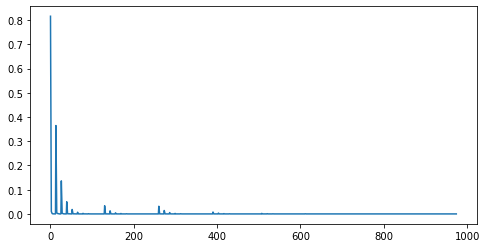

In [5]:
sound, fs = getSound("./SoundDatabase/BRA2S3786_20160215_152000.wav", 5)

descriptor = descriptorScalogram3(sound)
print(descriptor.shape)

plt.figure(figsize = (8, 4))
plt.plot(descriptor)
plt.show()

### Calcul du secripteur pour tous les sons

In [6]:
descriptorMatrix = computeAllDescriptors(descriptorScalogram3, "scalogram3", "scalogram3")

Loading descriptors from persisted file


### Analyse des valeurs propres

Number of eigenvalues necessary to explain 98 % of the variance: 2


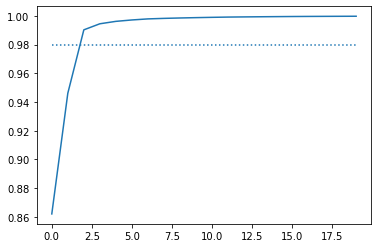

In [7]:
displayDescriptorEigenvalues(descriptorMatrix, 20, 0.98)

## Moyenne + ecart-type

In [8]:
def average_std(sound, J = 12, Q = 3):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound / np.max(np.abs(sound)))


    order2 = np.where(scattering.meta()['order'] == 2)

    descriptor = scalogram[order2]
    standard_deviation = np.std(descriptor, axis = 1)
    descriptor = np.mean(descriptor, axis = 1)
    descriptor = np.ravel([descriptor, standard_deviation])
    #descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor

(350,)


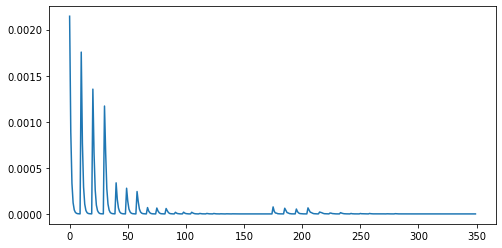

In [9]:
sound, fs = getSound("./SoundDatabase/BRA2S3786_20160216_152000.wav", 5)

descriptor = average_std(sound)
print(descriptor.shape)

plt.figure(figsize = (8, 4))
plt.plot(descriptor)
plt.show()

Loading descriptors from persisted file
Number of eigenvalues necessary to explain 96 % of the variance: 2


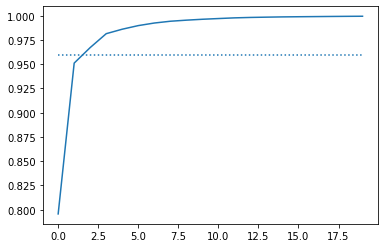

In [10]:
usualDescriptorMatrix = computeAllDescriptors(average_std, "average_std", "average_std")
displayDescriptorEigenvalues(usualDescriptorMatrix, 20, 0.96)


## Descripteur usuel non normalisé

In [11]:
def compute_usual_descriptor(sound, J = 12, Q = 3):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound / np.max(np.abs(sound)))


    order2 = np.where(scattering.meta()['order'] == 2)

    descriptor = scalogram[order2]
    descriptor = np.mean(descriptor, axis = 1)
    #descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor



(175,)


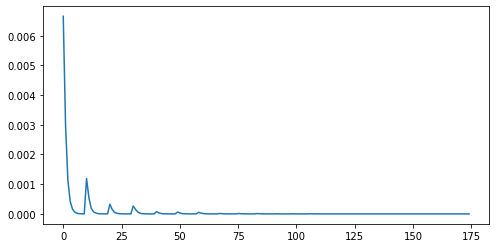

In [12]:
sound, fs = getSound("./SoundDatabase/BRA2S3786_20160215_152000.wav", 5)

descriptor = compute_usual_descriptor(sound)
print(descriptor.shape)

plt.figure(figsize = (8, 4))
plt.plot(descriptor)
plt.show()

Loading descriptors from persisted file
(432, 175)
Number of eigenvalues necessary to explain 95 % of the variance: 1


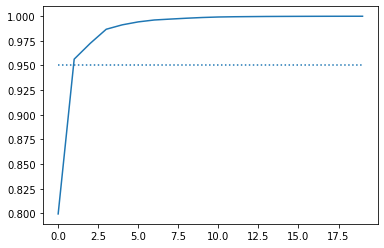

In [13]:
usualDescriptorMatrix = computeAllDescriptors(compute_usual_descriptor, "descriptors_non_normalized", "descriptors_non_normalized")
print(usualDescriptorMatrix.shape)
displayDescriptorEigenvalues(usualDescriptorMatrix, 20, 0.95)


## Test
``
    scalogram = scattering(sound) # seule changement enlever la normalization
``

In [14]:
def compute_usual_descriptor2(sound, J = 12, Q = 3):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound) # seule changement enlever la normalization


    order2 = np.where(scattering.meta()['order'] == 2)

    descriptor = scalogram[order2]
    descriptor = np.mean(descriptor, axis = 1)
    descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor



Loading descriptors from persisted file
(432, 175)
Number of eigenvalues necessary to explain 95 % of the variance: 1


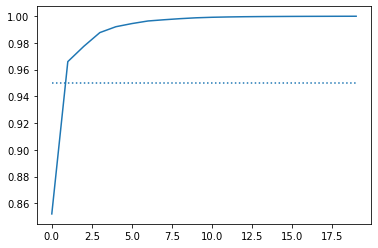

In [15]:
usualDescriptorMatrix = computeAllDescriptors(compute_usual_descriptor2, "descriptors_non_normalized2", "descriptors_non_normalized2")
print(usualDescriptorMatrix.shape)
displayDescriptorEigenvalues(usualDescriptorMatrix, 20, 0.95)


## Log du descripteur usuel

Loading descriptors from persisted file
Number of eigenvalues necessary to explain 100 % of the variance: 5


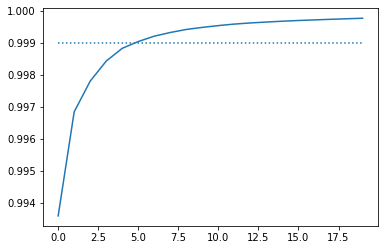

In [16]:
descriptorMatrix = getDescriptors(J = 12, Q = 3, verbose = True)

eps = 1e-16
descriptorMatrix = np.log(descriptorMatrix + eps)
descriptorMatrix = descriptorMatrix / np.linalg.norm(descriptorMatrix, axis = 1)[:, np.newaxis]

displayDescriptorEigenvalues(descriptorMatrix, 20, 0.999)

## Moyenne + Ecart-type + Skewness + Kurtosis

In [17]:
def average_std_skewness_kurtosis(sound, J = 8, Q = 3):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound / np.max(np.abs(sound)))


    order2 = np.where(scattering.meta()['order'] == 2)

    scalogram2 = scalogram[order2]

    avg = np.mean(scalogram2, axis = 1)
    avg = avg / np.linalg.norm(avg)
    #avg = (avg - np.min(avg)) / (np.max(avg) - np.min(avg))
    standard_deviation = np.std(scalogram2, axis = 1)
    standard_deviation = standard_deviation / np.linalg.norm(standard_deviation)
    #standard_deviation = (standard_deviation - np.min(standard_deviation)) / (np.max(standard_deviation) - np.min(standard_deviation))
    skewness = stats.skew(scalogram2, axis = 1)
    skewness = skewness / np.linalg.norm(skewness)
    #skewness = (skewness - np.min(skewness)) / (np.max(skewness) - np.min(skewness))
    kurtosis = stats.kurtosis(scalogram2, axis = 1)
    kurtosis = kurtosis / np.linalg.norm(kurtosis)
    #kurtosis = (kurtosis - np.min(kurtosis)) / (np.max(kurtosis) - np.min(kurtosis))

    descriptor = np.ravel([avg, standard_deviation, skewness, kurtosis])
    descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor

(276,)


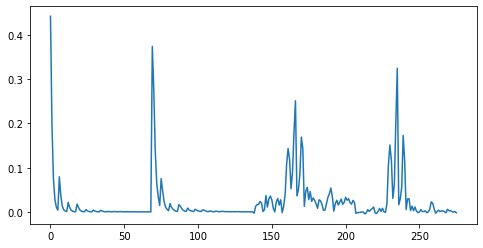

In [18]:
sound, fs = getSound("./SoundDatabase/BRA2S3786_20160215_152000.wav", 5)

descriptor = average_std_skewness_kurtosis(sound)
print(descriptor.shape)

plt.figure(figsize = (8, 4))
plt.plot(descriptor)
plt.show()

In [19]:
descriptorMatrix = computeAllDescriptors(average_std_skewness_kurtosis, "avg_std_skew_kurt", "avg_std_skew_kurt")

Loading descriptors from persisted file


Number of eigenvalues necessary to explain 100 % of the variance: 138


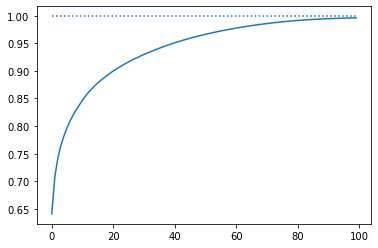

In [20]:
displayDescriptorEigenvalues(descriptorMatrix, 100, 0.999)

Loading pertinences from persisted file

Samples: ['BRA2S3786_20160214_145000.wav' 'BRA2S3786_20160215_053000.wav'
 'BRA2S3786_20160214_013000.wav' 'BRA2S3786_20160216_002000.wav'
 'BRA2S3786_20160214_204000.wav' 'BRA2S3786_20160215_021000.wav'
 'BRA2S3786_20160215_031000.wav' 'BRA2S3786_20160214_022000.wav'
 'BRA2S3786_20160214_035000.wav' 'BRA2S3786_20160216_212000.wav']

Pertinences list: [0.99174678 0.89755678 0.91736162 0.97781914 0.96689063 0.98813021
 0.99657589 0.97319579 0.97730213 0.98387438]
Average pertinence: 0.9670453369617462

diversity: 2.7902605988732278e-14



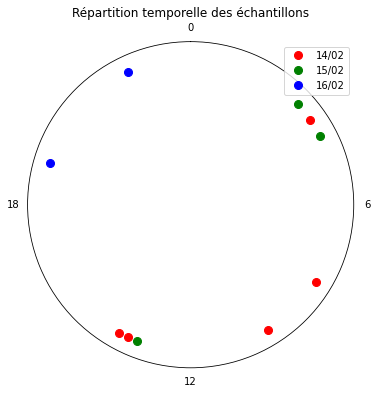

c:\Users\pierr\Documents\Travail\EI2\PROJET DETPOP\Github\Detpop\affichageDonnees.py:102: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(samples != []):


Extraction of birds from those samples : 6
{'whtspa', 'brwhaw', 'whsowl1', 'killde', 'whtkin2', 'bacspa'}


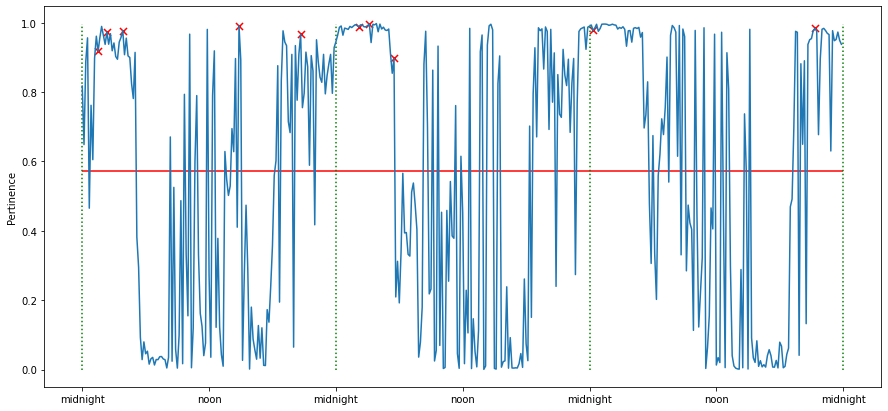

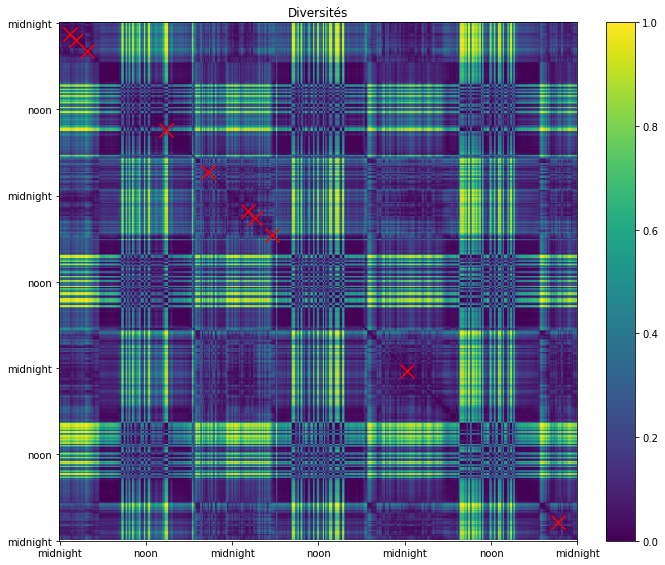

In [22]:
from echantillonnages import sampling_dpp
from affichageDonnees import present_sampling
from utils import getFilenamesAtPositions
from constructionPsi import getPertinences
from dppy.finite_dpps import FiniteDPP

def sampling_dpp(nbSamples, root = './SoundDatabase', J = 8, Q = 3, pertinenceFunction = 'identity'):

    descriptors = descriptorMatrix

    pertinences = getPertinences(pertinenceFunction = pertinenceFunction, root = root)

    pertinences = np.tile(pertinences, (descriptors.shape[1], 1)).T
    psi = np.multiply(descriptors, pertinences)

    DPP = FiniteDPP('likelihood', **{'L': psi.dot(psi.T)})

    samples_positions = DPP.sample_exact_k_dpp(size = nbSamples)

    samples = getFilenamesAtPositions(root, samples_positions)

    det = np.linalg.det(psi[samples_positions].dot(psi[samples_positions].T))

    return np.array(samples), det

nbSamples = 10
present_sampling(sampling_dpp, nbSamples)
